In [ ]:
#downgrade opencv to accomodate SIFT
! pip install opencv-python==3.4.2.17
! pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 25.0MB 1.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 149kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2, sys
from PIL import Image
import random


In [ ]:
def dlt(f, t, num_points=4):
	"""	Returns Homography matrix in which 'f' points are mapped to 't' points
		using Direct Linear Transform algorithm.
		t = Hf
	"""
	assert f.shape == t.shape
	num_points = f.shape[0]
	A = np.zeros((2*num_points, 9))
	for p in range(num_points):
		fh = np.array([f[p,0], f[p,1], 1])										# Homogenous coordinate of point p
		A[2*p] = np.concatenate(([0, 0, 0], -fh, t[p,1]*fh))					# [0' -wX' yX']
		A[2*p + 1] = np.concatenate((fh, [0, 0, 0], -t[p,0]*fh))				# [wX' 0' -xX']
	U, D, V = np.linalg.svd(A)
	H = V[8].reshape(3, 3)
	return H / H[-1,-1]


In [ ]:
class Panorama:
    """docstring for Panorama."""
    def __init__(self, img1, img2):
        """
        Numpy ndarray of img1 and img2
        """
        self.img1 = dict(array=img1)
        self.img2 = dict(array=img2)
        pass

    def construct_panorama(self, show=False, factor=0.7):
        self.get_interest_points(show=show)
        if self.putative_matches(factor=factor):
            self.ransac()
            self.stitch()
            print("Inliers:", self.num_inliers)
            return self.panorama
        else:
            return None
        pass

    def construct_panorama2(self, show=False, factor=0.7):
        self.get_interest_points(show=show)
        if self.putative_matches(factor=factor):
            self.ransac()
            self.mix_and_match()
            print("Inliers:", self.num_inliers)
            cropped_image = self.panorama[:(img1.shape[0]+200),:(3*img1.shape[1]),:]
            self.panorama=cropped_image
            return self.panorama
            
        else:
            return None
        pass

    def get_interest_points(self, show=False):
        # Initiate SIFT detector
        sift = cv2.xfeatures2d.SIFT_create()
        # find the keypoints and descriptors with SIFT
        keypts1, desc1 = sift.detectAndCompute(self.img1["array"], None)
        keypts2, desc2 = sift.detectAndCompute(self.img2["array"], None)

        # FLANN parameters: Fast Library for Approximate Nearest Neighbor
        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)

        # K=2 => get 2 Nearest Neighbors which is then filtered out after applying a ratio test
        # This filters out around 90% of false matches
        #(Learning OpenCV 3 Computer Vision with Python By Joe Minichino, Joseph Howse)
        matches = flann.knnMatch(desc2, desc1, k=2)                 # Interest points from image2 to image1

        if show:
            # Need to draw only good matches, so create a mask
            matchesMask = [[0,0] for i in range(len(matches))]
            # ratio test as per Lowe's paper
            for i,(m,n) in enumerate(matches):
                if m.distance < 0.7*n.distance:
                    matchesMask[i] = [1,0]

            draw_params = dict(matchColor = (0,255,0),
                               singlePointColor = (255,0,0),
                               matchesMask = matchesMask,
                               flags = 0)
            img3 = cv2.drawMatchesKnn(img1, keypts1, img2, keypts2, matches, None, **draw_params)
            plt.imshow(img3)
            plt.show()
            if img3.shape[2] == 4:
                img3 = cv2.cvtColor(img3, cv2.COLOR_BGRA2RGB)*256
            else:
                img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
            #cv2.imwrite(sys.argv[3], img3)
            plt.imshow(img3)
            plt.show()

        self.img1.update({'keypts' : keypts1, 'desc' : desc1})
        self.img2.update({'keypts' : keypts2, 'desc' : desc2})
        self.matches = matches
        pass

    def putative_matches(self, factor=0.7):
        # discarding any with a distance greater than 0.7 will help in getting rid of around 90% of false matches
        p_matches = [(p1.trainIdx, p1.queryIdx) for (p1, p2) in self.matches if p1.distance < factor*p2.distance]

        if len(p_matches) <= 4:
            print("Try with less value of factor than ", factor)
            return False
        self.img1.update({'matches' : np.array([list(self.img1["keypts"][i].pt) for (i,_) in p_matches])})
        self.img2.update({'matches' : np.array([list(self.img2["keypts"][i].pt) for (_,i) in p_matches])})
        self.num_matches = len(p_matches)
        return True

    def ransac(self, threshold_distance=0.5, threshold_inliers=0, ransac_iters=50):
        self.src_inliers = None
        self.dst_inliers = None
        self.homography = None
        for it in range(ransac_iters):
            indexes = random.sample(range(self.num_matches), 4)         # Randomly select four points
            fp = np.array([self.img2["matches"][pt] for pt in indexes])
            tp = np.array([self.img1["matches"][pt] for pt in indexes])
            homography = dlt(fp, tp)        # tp = H*fp
            src_pts = np.insert(self.img2["matches"], 2, 1, axis=1).T # Add column of 1 at the end (Homogenous coordinates)
            dst_pts = np.insert(self.img1["matches"], 2, 1, axis=1).T # Add column of 1 at the end (Homogenous coordinates)
            projected_pts = np.dot(homography, src_pts)
            error = np.sqrt(np.sum(np.square(dst_pts - (projected_pts/projected_pts[-1])), axis=0))
            if np.count_nonzero(error < threshold_distance) > threshold_inliers:
                print(it)
                self.src_inliers = src_pts[:, np.argwhere(error < threshold_distance).flatten()][:-1].T
                self.dst_inliers = dst_pts[:, np.argwhere(error < threshold_distance).flatten()][:-1].T
                self.homography = homography
                self.num_inliers = np.count_nonzero(error < threshold_distance)
                threshold_inliers = self.num_inliers
        pass

    def stitch(self):
		# self.left_list = reversed(self.left_list)
		#a = self.left_list[0]
		#for b in self.left_list[1:]:
        a = self.img1["array"]
        b= self.img2["array"]
        H = self.homography
        print ("Homography is : ", H)
        xh = np.linalg.inv(H)
        print ("Inverse Homography :", xh)
        ds = np.dot(xh, np.array([a.shape[1], a.shape[0], 1]));
        ds = ds/ds[-1]
        print ("final ds=>", ds)
        f1 = np.dot(xh, np.array([0,0,1]))
        f1 = f1/f1[-1]
        xh[0][-1] += abs(f1[0])
        xh[1][-1] += abs(f1[1])
        ds = np.dot(xh, np.array([a.shape[1], a.shape[0], 1]))
        offsety = abs(int(f1[1]))
        offsetx = abs(int(f1[0]))
        dsize = (int(ds[0])+offsetx, int(ds[1]) + offsety)
        print ("image dsize =>", dsize)
        tmp = cv2.warpPerspective(a, xh, dsize)

        print(b.shape[1]+offsetx)
        t = tmp[offsety:b.shape[0]+offsety, offsetx:b.shape[1]+offsetx].shape
        b = b[:,0:t[1],:]
        tmp[offsety:b.shape[0]+offsety, offsetx:b.shape[1]+offsetx] = b
        a = tmp
        self.panorama = tmp

    def mix_and_match(self):
        each = self.img2["array"]
        leftImage = self.img1["array"]
        H = self.homography
        txyz = np.dot(H, np.array([each.shape[1], each.shape[0], 1]))
        txyz = txyz/txyz[-1]
        dsize = (int(txyz[0])+leftImage.shape[1], int(txyz[1])+leftImage.shape[0])
        warpedImage = cv2.warpPerspective(each, H, dsize)
        i1y, i1x = leftImage.shape[:2]
        i2y, i2x = warpedImage.shape[:2]
        #print (leftImage[-1,-1])

        # = time.time()
        black_l = np.where(leftImage == np.array([0,0,0]))
        black_wi = np.where(warpedImage == np.array([0,0,0]))
        #print (time.time() - t)
        #print (black_l[-1])

        for i in range(0, i1x):
        	for j in range(0, i1y):
        		try:
        			if(np.array_equal(leftImage[j,i],np.array([0,0,0])) and  np.array_equal(warpedImage[j,i],np.array([0,0,0]))):
        				# print "BLACK"
        				# instead of just putting it with black,
        				# take average of all nearby values and avg it.
        				warpedImage[j,i] = [0, 0, 0]
        			else:
        				if(np.array_equal(warpedImage[j,i],[0,0,0])):
        					# print "PIXEL"
        					warpedImage[j,i] = leftImage[j,i]
        				else:
        					if not np.array_equal(leftImage[j,i], [0,0,0]):
        						bw, gw, rw = warpedImage[j,i]
        						bl,gl,rl = leftImage[j,i]
        						# b = (bl+bw)/2
        						# g = (gl+gw)/2
        						# r = (rl+rw)/2
        						warpedImage[j, i] = [bl,gl,rl]
        		except:
        			pass
        # cv2.imshow("waRPED mix", warpedImage)
        # cv2.waitKey()
        self.panorama = warpedImage



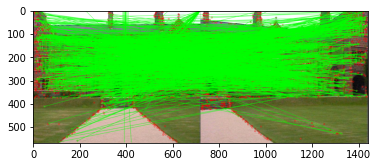

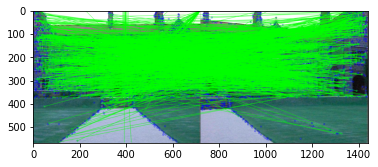

0
1
23
Inliers: 306


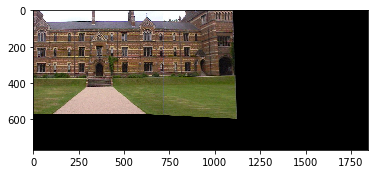

In [ ]:
img1 = mpimg.imread('keble_b.jpg')
img2 = mpimg.imread('keble_c.jpg')
pan = Panorama(img1, img2)
pano = pan.construct_panorama2(show=True)
plt.imshow(pano, interpolation="nearest")
plt.show()


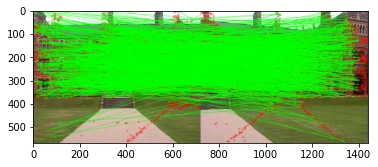

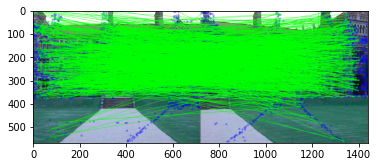

0
5
6
7
29
Inliers: 366


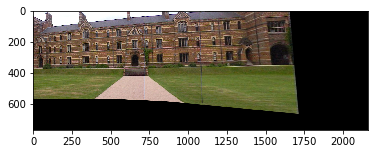

In [ ]:

img3 = mpimg.imread('keble_a.jpg')
pan1 = Panorama(img3, pano)
pano1 = pan1.construct_panorama2(show=True)
plt.imshow(pano1, interpolation="nearest")
plt.show()